# Интервальная торговая стратегия

## 1 Подготовительные действия

### 1.1 Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression

### 1.2 Подгружаем данные

In [4]:
src = pd.read_csv("data/TCSGDR.csv",
                  index_col="date",
                  parse_dates=["date"],
                  dayfirst=True,
                  thousands=".",
                  decimal=",")
src.sort_index(inplace=True)
src

,price,open,Max,Min,volume,change
date,,,,,,
2019-10-29,1219.8,1202.0,1226.0,1200.2,"68,38K","1,14%"
2019-10-30,1217.0,1225.0,1227.0,1212.8,"36,69K","-0,23%"
2019-10-31,1216.0,1221.4,1223.8,1210.2,"19,33K","-0,08%"
2019-11-01,1214.0,1218.4,1219.0,1212.6,"16,63K","-0,16%"
2019-11-05,1198.0,1217.8,1220.0,1197.4,"61,35K","-1,32%"
...,...,...,...,...,...,...
2022-04-25,1908.0,2185.0,2228.5,1908.0,"458,35K","-15,95%"
2022-04-26,2073.0,1880.0,2138.0,1870.0,"424,63K","8,65%"
2022-04-27,2520.0,2092.5,2690.5,2030.0,"778,72K","21,56%"


In [5]:
src.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 611 entries, 2019-10-29 to 2022-04-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   611 non-null    float64
 1   open    611 non-null    float64
 2   Max     611 non-null    float64
 3   Min     611 non-null    float64
 4   volume  611 non-null    object 
 5   change  611 non-null    object 
dtypes: float64(4), object(2)
memory usage: 33.4+ KB


In [6]:
prices = src.price.astype(np.float32)
prices

date
2019-10-29    1219.800049
2019-10-30    1217.000000
2019-10-31    1216.000000
2019-11-01    1214.000000
2019-11-05    1198.000000
                 ...     
2022-04-25    1908.000000
2022-04-26    2073.000000
2022-04-27    2520.000000
2022-04-28    2700.000000
2022-04-29    2608.000000
Name: price, Length: 611, dtype: float32

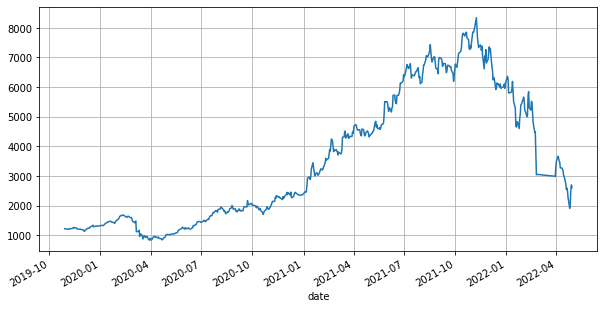

In [7]:
prices.plot(figsize=(10, 5), grid=True);

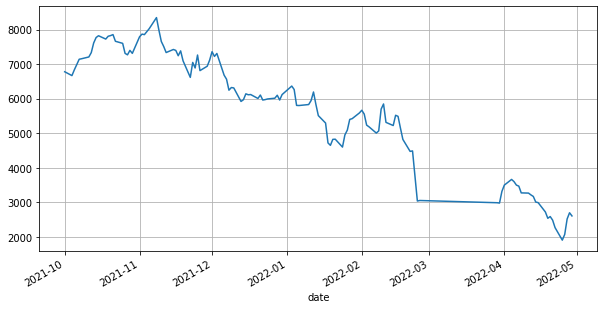

In [8]:
prices_tail = prices.loc["2021-10-01":].copy()
prices_tail.plot(figsize=(10, 5), grid=True);

## 2 Разработка стратегии

In [9]:
# Параметры стратегии
QUANT_LOWER_HOT_PROB = 0.01
QUANT_LOWER_PROB = 0.1
QUANT_UPPER_PROB = 0.9
QUANT_UPPER_HOT_PROB = 0.99


### 2.1 Линейная регрессия

In [10]:
df = pd.DataFrame(prices_tail)
df["num_index"] = np.arange(prices_tail.size)
df

,price,num_index
date,,
2021-10-01,6778.600098,0
2021-10-04,6667.200195,1
2021-10-05,6835.000000,2
2021-10-06,6986.200195,3
2021-10-07,7140.000000,4
...,...,...
2022-04-25,1908.000000,121
2022-04-26,2073.000000,122
2022-04-27,2520.000000,123


In [11]:
model = LinearRegression().fit(df[["num_index"]], df.price)

c:\users\chern_000\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


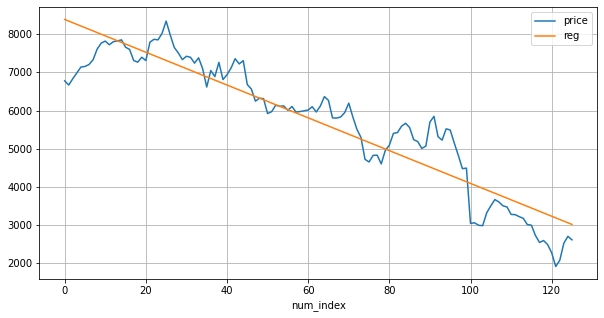

In [12]:
df["reg"] = model.predict(df.num_index.values.reshape(-1, 1))

df.plot("num_index", ["price", "reg"], figsize=(10, 5), grid=True);

### 2.2 Главные интервалы

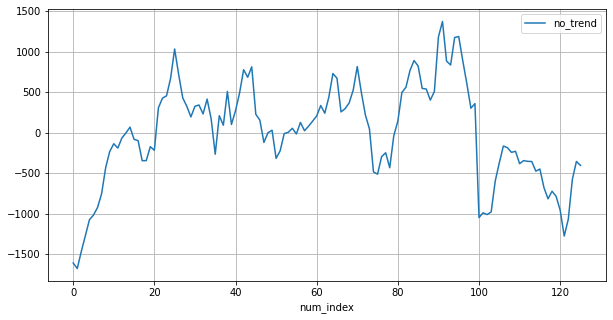

In [13]:
df["no_trend"] = df.price - df.reg
df.plot("num_index", "no_trend", figsize=(10, 5), grid=True);

In [14]:
q_lower_hot = df.no_trend.quantile(q=QUANT_LOWER_HOT_PROB)
q_lower = df.no_trend.quantile(q=QUANT_LOWER_PROB)
q_upper = df.no_trend.quantile(q=QUANT_UPPER_PROB)
q_upper_hot = df.no_trend.quantile(q=QUANT_UPPER_HOT_PROB)

q_lower_inner_1 = df.no_trend.quantile(q=0.3)
q_upper_inner_1 = df.no_trend.quantile(q=0.7)

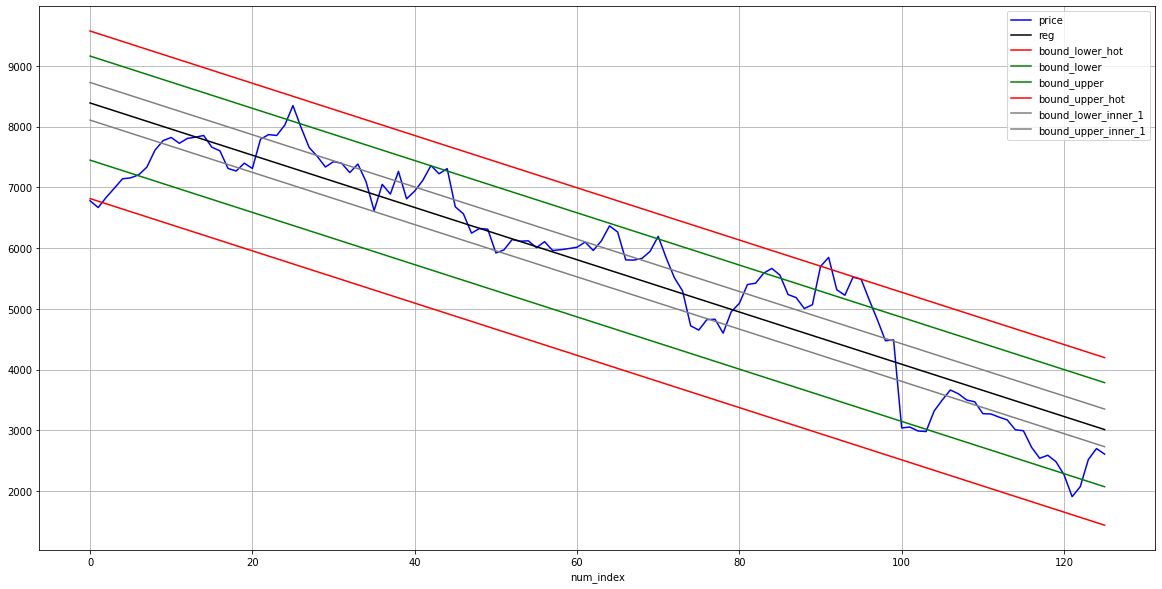

In [15]:
df["bound_lower_hot"] = model.coef_ * df.num_index + model.intercept_ + q_lower_hot
df["bound_lower"] = model.coef_ * df.num_index + model.intercept_ + q_lower
df["bound_upper"] = model.coef_ * df.num_index + model.intercept_ + q_upper
df["bound_upper_hot"] = model.coef_ * df.num_index + model.intercept_ + q_upper_hot

corridor_labels = ["reg", "bound_lower_hot", "bound_lower", "bound_upper", "bound_upper_hot"]

df["bound_lower_inner_1"] = model.coef_ * df.num_index + model.intercept_ + q_lower_inner_1
df["bound_upper_inner_1"] = model.coef_ * df.num_index + model.intercept_ + q_upper_inner_1

df.plot("num_index", ["price", *corridor_labels, "bound_lower_inner_1", "bound_upper_inner_1"],
        color=["b", "k", "r", "g", "g", "r", "gray", "gray"], figsize=(20, 10), grid=True);

In [16]:
print(f"Диапозон дат: {df.index[0].strftime('%Y-%m-%d')} - {df.index[-1].strftime('%Y-%m-%d')}")
print("Отсчет х для построения прямых начинается с нуля.")
print("Уравнение прямой: y = k*x + b")
print(f"k = {model.coef_[0]}")
print(f"""Коэффициент b от меньшего к большему:
    b_lowest = {model.intercept_ + q_lower_hot}
    b_lower = {model.intercept_ + q_lower}
    b_central = {model.intercept_}
    b_upper = {model.intercept_ + q_upper}
    b_uppermost = {model.intercept_ + q_upper_hot}
""")

Диапозон дат: 2021-10-01 - 2022-04-29
Отсчет х для построения прямых начинается с нуля.
Уравнение прямой: y = k*x + b
k = -43.00037519187057
Коэффициент b от меньшего к большему:
    b_lowest = 6814.200260838123
    b_lower = 7447.023637087846
    b_central = 8387.78218042569
    b_upper = 9160.02344949191
    b_uppermost = 9572.160174237866



## 3 Реализация стратегии

In [17]:
class BaseStrategy(BaseEstimator):
    pass

### 3.1 Реализация без памяти

In [18]:
class NumberedDate:
    def __init__(self,
                 time: pd.Timestamp,
                 working: bool,
                 num_of_last_working_date: int,
                 time_step: pd.Timedelta = None,
                 time_series_for_step: pd.DatetimeIndex = None):
        self.time = time
        self.working = working
        self.num_of_last_working_date = num_of_last_working_date
        if time_series_for_step is None:
            self.TIME_STEP = time_step
        else:
            self.TIME_STEP = (time_series_for_step[1:] - time_series_for_step[:-1]).min()

    def add_dates(self, dates, add_last_working_date=False):
        """

        :param add_last_working_date: if True then then adds a working day to a number of non-working days.
        :param dates: missed dates of formate pd.Series({time: bool}). True match to the working day.
        :return: True if the object has been changed.
        """
        dates = dates[dates.index > self.time].sort_index()
        if dates.empty:
            return False
        working_dates_num = np.count_nonzero(dates)

        next_date = self.time + self.TIME_STEP
        if dates[0] != next_date:
            if add_last_working_date and not working_dates_num:
                dates = pd.Series({next_date: True}).append(dates)
                working_dates_num += 1
            else:
                raise ValueError(
                    "The date immediately after the current model date was skipped."
                )

        if dates.size != 1:
            steps = dates[1:] - dates[:-1]
            if (steps != self.TIME_STEP).any():
                raise ValueError(
                    "The step of the passed time series does not correspond to the expected one."
                )

        self.working = dates[-1]
        self.time = dates.index[-1]
        self.num_of_last_working_date += working_dates_num
        return True

    def add_working_date(self, date: pd.Timestamp):
        return self.add_dates(pd.Series({date: True}))

In [19]:
class IntervalStrategyLite(BaseStrategy):
    def __init__(self):
        self.linreg = LinearRegression()
        self.coef_ = None
        self.reg_intercept_ = None

        self.bound_intercepts = ()

        self.first_train_date = pd.Timestamp("1970")  # First averaging
        self.last_train_date = pd.Timestamp("1970")  # Last averaging
        self.current_date = NumberedDate(time=pd.Timestamp("1970"),
                                         working=False,
                                         num_of_last_working_date=-1)

    def fit(self, data, quantiles=None, st_type=None):
        """ Fit model.

        :param quantiles:
        :param data: time series of formate pd.Series({time: value})
        :return: self
        """
        if quantiles is None:
            quantiles = (0.01, 0.1, 0.9, 0.99)

        df = pd.DataFrame(data.sort_index())
        df.rename({df.columns[0]: "target"}, inplace=True)  # TODO: change to NumPy
        df["x"] = np.arange(df.index.size)

        self.first_train_date = df.index[0]
        self.last_train_date = df.index[-1]
        self.current_date = NumberedDate(time=df.index[-1],
                                         working=True,
                                         num_of_last_working_date=df.x[-1],
                                         time_series_for_step=df.index)

        self.linreg.fit(df[["x"]], df.taget)
        self.coef_ = self.linreg.coef_[0]
        self.reg_intercept_ = self.linreg.intercept_

        df["no_trend"] = df.target - self.linreg.predict(df[["x"]])
        for i in range(len(quantiles)):
            self.bound_intercepts[i] = df.no_trend.quantile(q=quantiles[i])

        return self

    def trade(self, auto_fit=True):
        ...

    def solve(self, previous_step_value, current_values, current_date,
                    add_last_working_date=True, dates=None):
        """Trade only on the main borders

        :param current_values: numpy.ndarray. Values after the last averaging for which the solution is calculated
        :param previous_step_value: the value in the previous step
        :param dates: missed dates of formate pd.Series({time: bool}). True match to the working day. If the add_last_working_date flag is set, one working date will be added if one is skipped
        :param add_last_working_date: adds one working day if one working date is skipped between the model date and current_date
        :param current_date: Date matching current_value
        :return: "buy", "sell", "inaction"
        """
        if dates.index.max() >= current_date:
            raise ValueError(
                "The current_date passed is earlier than the date of the dates argument or the same."
            )

        if dates is None:
            next_date = self.current_date.time + self.current_date.TIME_STEP
            if add_last_working_date and ((next_date + self.current_date.TIME_STEP) == current_date):
                self.current_date.add_working_date(next_date)
        else:
            self.current_date.add_dates(dates, add_last_working_date)

    def _line(self, x, bias=0):
        return self.coef_ * x + self.reg_intercept_ + bias


### 3.2 Реализауия с памятью

In [20]:
class IntervalStrategyHeavy(BaseStrategy):
    def __init__(self):
        self.linreg = LinearRegression()
        self.coef_ = None
        self.reg_intercept_ = None

        self.bound_intercepts = ()

        self.data = pd.Series()
        self.earliest_date = pd.Timestamp("1")
        self.time_step = pd.Timedelta("1")

    def fit(self, data, main_borders_quantiles=None, inner_bounds_num=None, broker_commission=0.003):
        """ Fit model.

        :param inner_bound_num:
        :param quantiles:
        :param data: time series of formate pd.Series({time: value})
        :return: self
        """
        if main_borders_quantiles is None:
            main_borders_quantiles = np.array([0.01, 0.1, 0.9, 0.99])

        data = data.sort_index()
        self.earliest_date = data.index[0]
        self.time_step = (data.index[1:] - data.index[:-1]).min()
        data_index = pd.date_range(data.index.min(), data.index.max(), freq=self.time_step)
        self.data = pd.Series(0, index=data_index)
        self.data[data.index] = data.values

        df = pd.DataFrame(data)
        df.rename({df.columns[0]: "target"}, inplace=True)
        df["x"] = np.arange(df.index.size)

        self.linreg.fit(df[["x"]], df.taget)
        self.coef_ = self.linreg.coef_[0]
        self.reg_intercept_ = self.linreg.intercept_

        df["no_trend"] = df.target - self.linreg.predict(df[["x"]])
        self.bound_intercepts = np.sort(df.no_trend.quantile(main_borders_quantiles).values)
        self._set_inner_bounds(df["no_trend"],
                               main_borders_quantiles,
                               inner_bounds_num,
                               broker_commission)
        return self

    def trade(self,current_values, fund, buyer, seller,
              auto_fit=True, diversification=(0.5, 0.5), missing_data=None, current_date=None):
        """ A method for a one-time buy or sell.

        :param fund:
        :param buyer: signature: (amount_to_buy) -> (buys_number, change_from_buying).
        The amount of_to_buy is the amount for which several items are bought
        :param seller: signature: (selling_items_number) -> (items_sold_number, total_revenue).
        _total_revenue_ is revenue minus commissions but without income tax.
        :param auto_fit:
        :param diversification:
        :return:
        """
        ...

    def solve(self, current_values, diversification=(0.5, 0.5),
              missing_data=None, current_date=None):
        """Trade only on the main borders

        :param current_values: numpy.ndarray. Values after the last averaging for which the solution is calculated
        :param previous_step_value: the value in the previous step
        :return: "buy", "sell", "inaction"
        """
        if missing_data is not None:
            self.add_data(missing_data)

        if current_date is not None:
            next_date = self.data.index[-1] + self.time_step
            if (self.data.index[-1] != current_date) or (next_date != current_date):
                raise ValueError(
                    f"The current_date argument can only have values {self.data.index[-1]} and {next_date}."
                )
            self.data[current_date] = current_values.mean()

        diversification = pd.Series(0, index=diversification)
        if diversification.index.sum() != 1:
            raise ValueError(
                "The elements of the diversification argument must be equal to one in total."
            )

    def add_data(self, missing_data):
        missing_data = missing_data[missing_data.index > self.data.index[-1]].sort_index()
        if not missing_data.empty:
            if not self._is_matching_step(missing_data):
                raise ValueError(
                    f"A step equal to {self.time_step} is not observed for the missing_data argument."
                )
            self.data = pd.concat([self.data, missing_data])
            return True
        return False

    def get_last_date(self):
        return self.data.iloc[-1]

    # def set_params(self):
    #     pass

    def _set_inner_bounds(self, series_without_trend, main_borders_quantiles, inner_bounds_num, broker_commission):
        if inner_bounds_num is None:
            self._select_inner_bounds(series_without_trend, main_borders_quantiles, broker_commission)
        else:
            if inner_bounds_num == 0:
                inner_borders = []
            elif inner_bounds_num == 1:
                inner_borders = [self.reg_intercept_]
            else:
                inner_quantiles = np.linspace(main_borders_quantiles[1],
                                              main_borders_quantiles[2],
                                              inner_bounds_num + 2)[1:-1]
                inner_borders = series_without_trend.quantile(inner_quantiles).values

            self.bound_intercepts = np.sort(np.concatenate([inner_borders, self.bound_intercepts]))

    def _select_inner_bounds(self, series_without_trend, main_borders_quantiles, broker_commission):
        ...

    def _is_matching_step(self, data):
        full_series = pd.concat([self.data[[-1]], data])
        return ((full_series[1:] - full_series[:-1]) == self.time_step).all()

    def _line(self, x, bias=0):
        return self.coef_ * x + self.reg_intercept_ + bias

In [21]:
raise ValueError(
    " ".join([
        "The date of the latest non-working day is too far from the current model date.",
        "Use the fill_in_dates method to change the current date."
    ])
)

ValueError: The date of the latest non-working day is too far from the current model date. Use the fill_in_dates method to change the current date.

In [36]:
np.concatenate([[1, 3], [2, 4]]).reshape(-1, 2)

array([[1, 3],
       [2, 4]])

In [24]:
pd.Series(0, index=df.price.quantile([0.1, 0.9]))

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_9076/2704581315.py, line 1)

In [ ]:
np.count_nonzero(pd.Series([23, 0]))

In [ ]:
t = pd.Series(0, index=pd.date_range(df.index.min(), df.index.max(), freq=(df.index[1:] - df.index[:-1]).min()))
t[df.index] = df.price.values
t.empty

In [ ]:
t[pd.DatetimeIndex(["2021-10-01", "2021-09-01"])] = [-10, -9]

In [ ]:
pd.concat([pd.Series({pd.Timestamp("2021-09-02"): -9}), t])
t[pd.Timestamp("2021-09-03")] = -3
t

In [ ]:
(df.index[1:] - df.index[:-1]).min()

In [ ]:
(df.index[1] - df.index[0]) > (df.index[1:] - df.index[:-1]).min() < pd.Timedelta(0)

In [ ]:
def solve_type1():


### 3.3 Пример использования

In [ ]:
def buy(egor_params):
    def _inner_buy(amount_to_buy):
        pass
    return _inner_buy

model = IntervalStrategy()
model.fit(prices_tail, quantiles=None, auto_type=True)
while True:
    model.trade(buyer=buy())
    break # если пользователь сказал начать продажу
while not model.soft_sell():
    pass